In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

In [3]:
trainset_sub = Subset(trainset, indices=range(6400))
trainloader = torch.utils.data.DataLoader(trainset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)
testset_sub = Subset(trainset, indices=range(1000))
testloader = torch.utils.data.DataLoader(testset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)

In [6]:
class model_MNIST(nn.Module):
    def __init__(self):
        super(model_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = x.reshape(x.shape[0], 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train(self, batches):
        losses = []
        running_loss = 0.0
        for i, batch in enumerate(batches):
            X_batch, y_batch = batch 
            
            X_batch = X_batch.to()
            y_batch = y_batch.to()
          

            self.optimizer.zero_grad()
            
            y_pred = self.forward(X_batch)
            loss = self.loss_fn(y_pred, y_batch)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            
            #print(i, loss.item())
            if i % 200 == 199:
                print('{} loss: {}'.format(i + 1, 
                                           round(running_loss / 200, 
                                                 3)))
                losses.append(running_loss)
                running_loss = 0.0 
                
        plt.plot(np.arange(len(losses)), losses)
        plt.show()
        print('train ended')
        
    def test(self, data):
        class_correct = list(0 for i in range(10))
        class_total = list(0 for i in range(10))
        classes = np.arange(10)
        
        with torch.no_grad():
            for i, batch in enumerate(data):
                images, labels = batch
                y_pred = self.forward(images)
                _, predicted = torch.max(y_pred, 1)
                
                checker = (predicted.detach() == labels)
                
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += checker[i].item()
                    class_total[label] += 1
                if i == 999:
                    break
                    
        for idx, num_class in enumerate(classes):
            print('Accuracy of {}: {}'.format(num_class, round(class_correct[idx] / class_total[idx] * 100, 3)))
        
        print('Mean accuracy = {}'.format(sum(class_correct) / sum(class_total) * 100))

In [7]:
class gatedPool(nn.Module):
    def __init__(self, in_channel, kernel_size, stride, padding = 0, learn_option='l/c'):
        super(gatedPool, self).__init__()
        
        if learn_option == 'l/c':
            self.mask = nn.Parameter(torch.randn(in_channel,
                                                 in_channel,
                                                 kernel_size,
                                                 kernel_size).float())
        elif learn_option == 'l':
            self.mask = nn.Parameter(torch.randn(1,
                                                 1,
                                                 kernel_size,
                                                 kernel_size).float())
        else:
            raise NameError(learn_option)
            
        self.learn_option = learn_option
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
         
    def forward(self, x):
        if self.learn_option == 'l/c':
            return self.layer_channel(x)
        if self.learn_option == 'l':
            return self.layer(x)
        
    def layer(self, x):
        size = list(x.size())[1]
        channels_gated = []
        
        for ch in range(size):
            a = x[:,ch,:,:]
            a = torch.unsqueeze(a,1)
            a = F.conv2d(a,self.mask,stride = self.stride)
            channels_gated.append(a)
            
        gated = channels_gated[0]
        
        for channel_gated in channels_gated[1:]:
            gated = torch.cat((gated,channel_gated),1)
        
        alpha = F.sigmoid(gated)
    
        x = alpha * F.max_pool2d(x,
                                 self.kernel_size,
                                 self.stride,
                                 self.padding) + (1-alpha)*F.avg_pool2d(x,
                                                                        self.kernel_size,
                                                                        self.stride,
                                                                        self.padding)
        
        return x 
    
    def layer_channel(self, x):
        mask_c = F.conv2d(x,self.mask,stride = self.stride)
        alpha = F.sigmoid(mask_c)
        x = alpha * F.max_pool2d(x,
                                 self.kernel_size,
                                 self.stride,
                                 self.padding) + (1-alpha) * F.avg_pool2d(x,
                                                                          self.kernel_size,
                                                                          self.stride, 
                                                                          self.padding)

        return torch.Tensor(x) 

In [8]:
class model_MNIST_gatedPool(model_MNIST):
    def __init__(self):
        super(model_MNIST_gatedPool, self).__init__()
        self.pool1 = gatedPool(6, 2, 2)
        self.pool2 = gatedPool(16, 2, 2)

c:\users\vera\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200 loss: 2.279
400 loss: 1.955
600 loss: 1.089
800 loss: 0.713
1000 loss: 0.659
1200 loss: 0.548
1400 loss: 0.548
1600 loss: 0.517


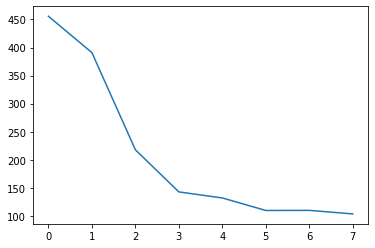

train ended


In [9]:
m4_gated = model_MNIST_gatedPool()
m4_gated.train(trainloader)

In [10]:
m4_gated.test(testloader)

c:\users\vera\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of 0: 97.938
Accuracy of 1: 92.241
Accuracy of 2: 80.808
Accuracy of 3: 79.57
Accuracy of 4: 88.571
Accuracy of 5: 55.435
Accuracy of 6: 93.617
Accuracy of 7: 86.325
Accuracy of 8: 86.207
Accuracy of 9: 76.0
Mean accuracy = 84.0
